<font size="6"><center>**Alpha Research: Evaluation**</font>

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%run ../nb_config.py

running notebook configuration


In [3]:
import numpy as np
import pandas as pd

In [4]:
from src.data_api import sources
from src import utils, tags

from src import data_preparation as dataprep 

In [5]:
conf = utils.get_conf()

In [6]:
fparams = conf['func_params']

start_dt = '2014-01-01'#fparams['start_dt']
end_dt = '2015-12-31'#fparams['end_dt']
avol_top = 1000 #float(fparams['avol_top'])
avol_window = int(fparams['avol_window'])
tau = int(fparams['target']['tau'])

In [7]:
ticker = 'AMZN'

# Load Data

In [8]:
wiki_prices = sources.read_wiki_prices()

In [9]:
pd.concat([wiki_prices.head(2), wiki_prices.tail(2)], axis=0)

,,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,ticker,,,,,,,,,,,,
1999-11-18,A,45.5000,50.0000,40.0000,44.0000,"44,739,900.0000",0.0000,1.0000,31.0420,34.1120,27.2896,30.0186,"44,739,900.0000"
1999-11-19,A,42.9400,43.0000,39.8100,40.3800,"10,897,100.0000",0.0000,1.0000,29.2954,29.3363,27.1600,27.5489,"10,897,100.0000"
2018-03-26,ZUMZ,23.7500,24.8000,23.7000,24.6500,"375,320.0000",0.0000,1.0000,23.7500,24.8000,23.7000,24.6500,"375,320.0000"
2018-03-27,ZUMZ,24.6500,24.6500,23.3500,23.6000,"403,884.0000",0.0000,1.0000,24.6500,24.6500,23.3500,23.6000,"403,884.0000"


In [10]:
wiki_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1999-11-18 00:00:00'), 'A') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Columns: 12 entries, open to adj_volume
dtypes: float64(12)
memory usage: 1.4+ GB


In [11]:
wiki_prices_meta = (sources.read_data(filename='us_equities_meta_data.csv', layer='raw')
                   .set_index(tags.TICKER)
                   )

wiki_prices_meta.head()

,name,lastsale,marketcap,ipoyear,sector,industry
ticker,,,,,,
PIH,"1347 Property Insurance Holdings, Inc.",7.2001,"43,090,000.0000","2,014.0000",Finance,Property-Casualty Insurers
PIHPP,"1347 Property Insurance Holdings, Inc.",25.6200,NaN,NaN,Finance,Property-Casualty Insurers
TURN,180 Degree Capital Corp.,2.2600,"70,330,000.0000",NaN,Finance,Finance/Investors Services
FLWS,"1-800 FLOWERS.COM, Inc.",12.9000,"833,390,000.0000","1,999.0000",Consumer Services,Other Specialty Stores
FCCY,1st Constitution Bancorp (NJ),21.3000,"178,140,000.0000",NaN,Finance,Savings Institutions


# Data Preparation

In [12]:
wiki_prices.head(2)

,,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,ticker,,,,,,,,,,,,
1999-11-18,A,45.5000,50.0000,40.0000,44.0000,"44,739,900.0000",0.0000,1.0000,31.0420,34.1120,27.2896,30.0186,"44,739,900.0000"
1999-11-19,A,42.9400,43.0000,39.8100,40.3800,"10,897,100.0000",0.0000,1.0000,29.2954,29.3363,27.1600,27.5489,"10,897,100.0000"


In [13]:
wiki_prices[['adj_open', 'adj_close', 'adj_high', 'adj_low']].dtypes

adj_open     float64
adj_close    float64
adj_high     float64
adj_low      float64
dtype: object

In [14]:
wiki_prices[['adj_open', 'adj_close', 'adj_high', 'adj_low']].isna().sum(axis=0)

adj_open     538
adj_close      1
adj_high      55
adj_low       55
dtype: int64

In [15]:
from src import data_preparation as dataprep 

min_yr = '2013'  # must be before start_dt (consdering feature windows)
select_cols = ['adj_open','adj_high','adj_low', 'adj_close', 'adj_volume']

mask_min_yr = wiki_prices.index.get_level_values(tags.DATE)>=pd.Timestamp(min_yr)

feats_and_targets = (wiki_prices
    .loc[mask_min_yr, select_cols]
    .pipe(dataprep.pl_min_avol_filter, window=avol_window, top_n=avol_top)
    .pipe(dataprep.pl_add_sector, sector_map=wiki_prices_meta['sector'])
    .pipe(dataprep.pl_targets, tau_fwd=tau)
    .pipe(dataprep.pl_features)
    .pipe(dataprep.pl_date_filter, start_dt=start_dt, end_dt=end_dt)
    .filter(regex=('x_|y_|sector'))
                    )


In [16]:
pd.concat([feats_and_targets.head(2), feats_and_targets.tail(2)], axis=0)

,,sector,y_fwd_logrets_5d,x_returns_5d,x_returns_1y,x_ohlc_intraday
date,ticker,,,,,
2014-01-02,A,Capital Goods,0.0384,-0.0157,0.3250,-3
2014-01-03,A,Capital Goods,0.0347,-0.0071,0.3516,3
2015-10-21,ZUMZ,Consumer Services,0.0724,0.0006,NaN,-3
2015-10-22,ZUMZ,Consumer Services,0.0820,-0.0206,NaN,-1


In [17]:
feats_and_targets.shape

(502482, 5)

In [ ]:
feats_and_targets.loc[pd.Timestamp('2015-10-22')]

## Feature Engineering

In [ ]:
feats_and_targets['x_returns_1y_fte'] = (
    feats_and_targets
        .pipe(dataprep.factor_demean, factor_col='x_returns_1y',  date_col='date', sector_col='sector', return_frame=True)
        .pipe(dataprep.factor_zscore, factor_col='x_returns_1y', date_col='date', return_frame=True)
        ) 

# Evaluation

In [20]:
cols_features = ['x_returns_1y_fte', 'x_returns_5d', 'x_ohlc_intraday']
cols_all = cols_features + [tags.TARGET]

In [21]:
corr = feats_and_targets[cols_all].corr(method='spearman')

In [22]:
corr.loc[cols_features, tags.TARGET]

x_returns_1y_fte    0.0375
x_returns_5d       -0.0243
x_ohlc_intraday    -0.0090
Name: y_fwd_logrets_5d, dtype: float64

In [23]:
corr_by_year = (feats_and_targets
                  .groupby(feats_and_targets.index.get_level_values(tags.DATE).year)[cols_all]
                  .corr(method='spearman')
                  .xs(level=1, key=tags.TARGET)[cols_features]
                 )

In [24]:
corr_by_year

,x_returns_1y_fte,x_returns_5d,x_ohlc_intraday
date,,,
2014,0.0277,-0.0072,0.0033
2015,0.0496,-0.0436,-0.0222


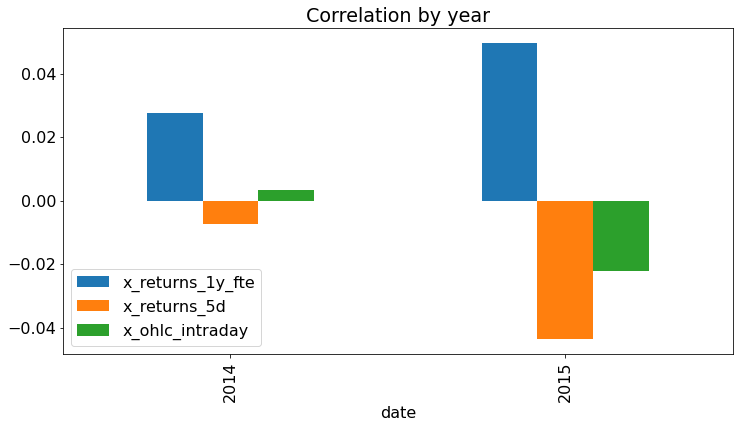

In [25]:
corr_by_year.plot.bar()
plt.title("Correlation by year")
plt.show()

In [26]:
corr_by_sector = (feats_and_targets
                  .groupby('sector')[cols_all]
                  .corr(method='spearman')
                  .xs(level=1, key=tags.TARGET)[cols_features]
                 )

In [27]:
corr_by_sector

,x_returns_1y_fte,x_returns_5d,x_ohlc_intraday
sector,,,
Basic Industries,0.0314,0.0036,0.0108
Capital Goods,0.0346,-0.0460,-0.0001
Consumer Durables,-0.0160,-0.0379,0.0040
Consumer Non-Durables,0.0757,-0.0448,-0.0128
Consumer Services,0.0228,-0.0315,-0.0139
Energy,0.0419,-0.0117,-0.0049
Finance,0.0168,-0.0700,-0.0145
Health Care,0.0124,-0.0383,-0.0240
Miscellaneous,0.0228,-0.0498,-0.0183


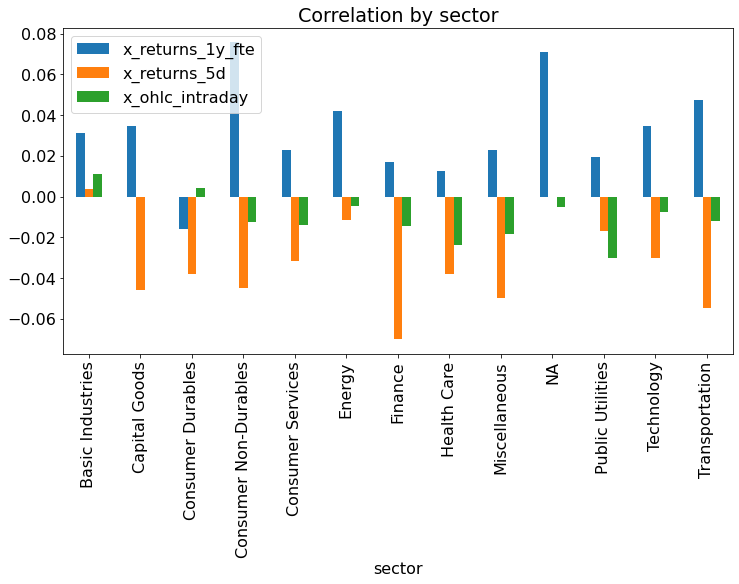

In [28]:
corr_by_sector.plot.bar()
plt.title("Correlation by sector")
plt.show()

# Alphalens

In [29]:
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import factor_returns as al_factor_returns

ModuleNotFoundError: No module named 'alphalens'

In [ ]:
factor_name = 'x_returns_1y_fte'
factor_data = feats_and_targets[factor_name]

In [ ]:
all_tickers = (factor_data.index
               .get_level_values(tags.TICKER)
               .unique().tolist()
              )

In [ ]:
pd.Timestamp.today()

In [ ]:
prices = (
    wiki_prices.pipe(dataprep.pl_date_filter, start_dt, pd.Timestamp.today())
    .query(f'ticker in {all_tickers}')[tags.CLOSE]
    .unstack(tags.TICKER)
)

prices.head(2)

In [ ]:
HOLDING_PERIODS = (1, 5, )
QUANTILES = 5
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=HOLDING_PERIODS,
                                                      quantiles=QUANTILES)

In [ ]:
alphalens_data.head()

In [ ]:
ex_ticker = 'AAPL'
ex_tau = 1
ex_date = pd.Timestamp('2015-01-05')
prices_ex = prices[ex_ticker]

In [ ]:
ex_date_tau = ex_date + pd.tseries.offsets.BusinessDay(5)
ex_date_tau

In [ ]:
prices.loc[ex_date:, ex_ticker].head(6)

In [ ]:
ex_return = (prices_ex.loc[ex_date_tau] - prices_ex.loc[ex_date]) / prices_ex.loc[ex_date]
ex_return

In [ ]:
# alpha lens uses the contrary sign convention, 
alphalens_data.loc[(pd.Timestamp(ex_date), ex_ticker), '5D']

In [ ]:
factor_data.loc[(ex_date, ex_ticker)]

In [ ]:
assert np.isclose(ex_return, alphalens_data.loc[(ex_date, ex_ticker), '5D'])
assert np.isclose(factor_data.loc[(ex_date, ex_ticker)], alphalens_data.loc[(ex_date, ex_ticker), 'factor'])

In [ ]:
#, alphalens_data.index.get_level_values('asset').unique()
#pd.testing.assert_series_equal(
#    pd.qcut(factor_data.loc[ex_date], 5).sort_index(),
#    alphalens_data.loc[ex_date, 'factor_quantile'].sort_index(),
#    check_names=False
#)
#    

In [ ]:
alphalens_data[['factor', '5D']].corr()

In [ ]:
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

In [ ]:
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

plot_quantile_returns_bar(mean_return_by_q)
plt.tight_layout()
sns.despine();

In [ ]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)

plot_cumulative_returns_by_quantile(mean_return_by_q_daily['5D'], period='5D', freq=None)
plt.tight_layout()
sns.despine();

In [ ]:
ic = factor_information_coefficient(alphalens_data)
plot_ic_ts(ic[['5D']])
plt.tight_layout()
sns.despine();

In [ ]:
ic = factor_information_coefficient(alphalens_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14, 6))
plt.tight_layout();

In [ ]:
df_factor_return = al_factor_returns(alphalens_data)

In [ ]:
cum_rets = (1+df_factor_return).cumprod()

In [ ]:

g = cum_rets.plot(linestyle = '-', figsize=(16,8))
plt.title('Accumulated Forward (Weighted) Returns by factor')
plt.ylabel("%")
plt.show()